# Batch Normalization
One way to make deep networks easier to train is to use more sophisticated optimization procedures such as SGD+momentum, RMSProp, or Adam. Another strategy is to change the architecture of the network to make it easier to train. 
One idea along these lines is batch normalization which was proposed by [3] in 2015.

The idea is relatively straightforward. Machine learning methods tend to work better when their input data consists of uncorrelated features with zero mean and unit variance. When training a neural network, we can preprocess the data before feeding it to the network to explicitly decorrelate its features; this will ensure that the first layer of the network sees data that follows a nice distribution. However, even if we preprocess the input data, the activations at deeper layers of the network will likely no longer be decorrelated and will no longer have zero mean or unit variance since they are output from earlier layers in the network. Even worse, during the training process the distribution of features at each layer of the network will shift as the weights of each layer are updated.

The authors of [3] hypothesize that the shifting distribution of features inside deep neural networks may make training deep networks more difficult. To overcome this problem, [3] proposes to insert batch normalization layers into the network. At training time, a batch normalization layer uses a minibatch of data to estimate the mean and standard deviation of each feature. These estimated means and standard deviations are then used to center and normalize the features of the minibatch. A running average of these means and standard deviations is kept during training, and at test time these running averages are used to center and normalize features.

It is possible that this normalization strategy could reduce the representational power of the network, since it may sometimes be optimal for certain layers to have features that are not zero-mean or unit variance. To this end, the batch normalization layer includes learnable shift and scale parameters for each feature dimension.

[3] [Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.](https://arxiv.org/abs/1502.03167)

In [1]:
# As usual, a bit of setup
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def print_mean_std(x,axis=0):
    print('  means: ', x.mean(axis=axis))
    print('  stds:  ', x.std(axis=axis))
    print() 

run the following from the cs231n directory and try again:
python setup.py build_ext --inplace
You may also need to restart your iPython kernel


In [2]:
# Load the (preprocessed) CIFAR10 data.
data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


## Batch normalization: forward
In the file `cs231n/layers.py`, implement the batch normalization forward pass in the function `batchnorm_forward`. Once you have done so, run the following to test your implementation.

Referencing the paper linked to above would be helpful!

In [4]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization   

# Simulate the forward pass for a two-layer network
np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before batch normalization:')
print_mean_std(a,axis=0)

gamma = np.ones((D3,))
beta = np.zeros((D3,))
# Means should be close to zero and stds close to one
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=0)

gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
# Now means should be close to beta and stds close to gamma
print('After batch normalization (gamma=', gamma, ', beta=', beta, ')')
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=0)

Before batch normalization:
  means:  [ -2.3814598  -13.18038246   1.91780462]
  stds:   [27.18502186 34.21455511 37.68611762]

After batch normalization (gamma=1, beta=0)
  means:  [ 9.71445147e-19  1.75207071e-18 -1.30104261e-19]
  stds:   [0.03678496 0.02922733 0.02653497]

After batch normalization (gamma= [1. 2. 3.] , beta= [11. 12. 13.] )
  means:  [11. 12. 13.]
  stds:   [0.03678496 0.05845465 0.07960491]



In [14]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)

for t in range(50):
  X = np.random.randn(N, D1)
  a = np.maximum(0, X.dot(W1)).dot(W2)
  batchnorm_forward(a, gamma, beta, bn_param)

bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print_mean_std(a_norm,axis=0)

(array([[ 9.59450615e-03,  5.13935001e-02,  2.67858138e-02],
        [ 2.32983159e-02, -3.52547775e-02,  2.67681510e-02],
        [ 3.53937780e-02, -7.48990568e-02, -2.36137268e-02],
        [ 3.75738573e-03,  3.11156994e-02, -2.43925839e-02],
        [-3.32711973e-02,  6.69490010e-03, -5.81473650e-02],
        [ 2.69481639e-02,  7.88267841e-03,  4.17764398e-04],
        [ 1.65070741e-02,  1.12976575e-02,  1.78348757e-02],
        [-3.54064661e-02, -1.89967461e-02,  6.13037600e-03],
        [ 5.14330481e-02, -4.26670103e-02, -4.68826085e-02],
        [-2.40120901e-02,  9.68860137e-03,  1.19349906e-03],
        [ 4.62428574e-02, -6.21195651e-05,  6.94756893e-03],
        [ 4.50778556e-04, -6.69587309e-02, -3.28701950e-02],
        [ 7.54529283e-03, -1.03542969e-02,  2.90051710e-02],
        [ 1.65879296e-02, -7.01360651e-03, -3.94414724e-03],
        [ 2.70222590e-02,  1.91393583e-02,  4.57482319e-02],
        [-4.49189219e-02,  4.08473304e-02,  2.69877392e-02],
        [-3.32334724e-03

(array([[ 6.65339265e-03,  9.82929172e-03,  8.32197148e-03],
        [ 1.79517289e-02,  1.84251633e-02,  2.02516402e-02],
        [-5.26789534e-04, -3.92820580e-03, -2.36843102e-02],
        [-5.67849702e-02, -3.08666223e-02, -1.16892156e-02],
        [ 1.81314699e-03,  5.84522493e-02, -1.39589928e-02],
        [ 2.49304298e-03,  2.37633678e-02,  1.80197700e-02],
        [-4.38591329e-03, -2.15807410e-02, -1.82394273e-02],
        [-1.43296906e-02, -4.89889160e-02, -7.95957771e-02],
        [-2.09114387e-02,  1.64859931e-02, -2.48328583e-02],
        [-3.81207797e-02,  1.80960515e-02,  3.72565865e-02],
        [ 1.16548982e-02,  1.46831625e-02,  2.15713975e-02],
        [ 2.24722429e-02, -4.68193609e-02, -1.96419405e-02],
        [-2.24693200e-04,  4.74822991e-02,  8.55684580e-03],
        [-4.20163040e-03, -2.01982682e-02, -4.29350698e-02],
        [-1.25857091e-02,  6.34664257e-02,  1.52287817e-02],
        [ 3.80248633e-02,  3.59811035e-02,  8.53109472e-03],
        [ 1.41209603e-03

(array([[ 3.66987646e-03,  2.16993653e-02,  3.14516373e-02],
        [-5.41093252e-02, -1.57978176e-02, -7.70290577e-03],
        [ 3.33098597e-02, -1.13863167e-02,  2.09673370e-02],
        [ 2.19787076e-02, -3.52625636e-02,  9.30497832e-04],
        [-1.91646421e-02, -2.39320290e-02, -2.15762131e-02],
        [-2.40462514e-02,  1.58798434e-02, -2.37696530e-02],
        [-4.59439250e-02, -5.03826375e-03, -3.33677487e-03],
        [-1.10785547e-02, -9.18045736e-02, -1.85629325e-02],
        [-2.12126888e-02, -6.18325683e-03,  2.97408256e-02],
        [-6.74480794e-03, -8.05772509e-03,  2.74360169e-03],
        [-8.39649711e-04,  3.10247528e-02,  2.62206515e-04],
        [ 2.83541344e-03,  2.33063809e-02,  1.96890853e-04],
        [ 1.09374357e-02,  1.14868975e-02, -2.00121044e-03],
        [ 1.64220649e-02,  3.09551874e-03,  1.27492870e-02],
        [ 6.99293294e-02,  1.04667349e-02,  3.13049930e-02],
        [ 3.95483453e-02,  1.48270415e-02,  1.93628030e-04],
        [ 4.52775429e-03

(array([[-5.85406185e-03, -4.63315763e-03, -7.59805330e-03],
        [-3.80373287e-02, -2.79814517e-02, -2.59997949e-02],
        [ 1.64412638e-02, -1.75587051e-02,  9.64038348e-05],
        [ 2.11115001e-02, -3.78410464e-02, -8.48012111e-02],
        [ 3.15731525e-02, -3.00142644e-02,  1.05000165e-02],
        [ 2.10118178e-02, -2.59338341e-02,  1.77110327e-02],
        [-6.52139669e-02,  3.98359611e-03,  9.15855948e-03],
        [-8.69021820e-03,  1.51696662e-02,  9.23711828e-03],
        [ 1.34131767e-02, -5.04954144e-02, -2.85391140e-02],
        [-2.82320226e-02,  1.42992871e-02,  2.28702805e-02],
        [ 3.35858981e-02, -4.83482382e-02, -1.09253897e-02],
        [ 3.41999302e-02,  1.54986880e-03,  3.46417818e-02],
        [ 1.93701818e-02,  3.08545857e-04,  1.27754205e-02],
        [ 5.46883260e-03,  2.29556612e-02,  6.49810389e-03],
        [-9.94153037e-04,  4.36178088e-02,  4.82989291e-02],
        [ 1.96413965e-02, -1.50708314e-02,  1.59088466e-02],
        [-1.57623168e-02

(array([[-0.03423134,  0.03107157, -0.01332357],
        [ 0.02545192,  0.0270775 ,  0.03310787],
        [-0.06891669, -0.01017871, -0.04013259],
        [ 0.01798194,  0.0180289 , -0.00332504],
        [ 0.03147003,  0.02101014,  0.03374269],
        [-0.02445967, -0.05118986, -0.01522538],
        [-0.03575118,  0.01621508, -0.05095898],
        [-0.01118874,  0.0320039 ,  0.04477163],
        [ 0.06505228, -0.0478574 ,  0.01256704],
        [ 0.0004678 , -0.01532329,  0.00432195],
        [-0.00775655, -0.01504576, -0.02354306],
        [ 0.02183547, -0.00914592, -0.06316428],
        [-0.02549492,  0.00493635, -0.00376833],
        [-0.00421649, -0.01203586, -0.07157121],
        [ 0.02444881,  0.02872353, -0.03408229],
        [-0.0270666 ,  0.09806653,  0.01460061],
        [-0.02895861, -0.03529201,  0.00134549],
        [-0.01336833,  0.00971556,  0.03566061],
        [-0.05321327, -0.03524743, -0.02532337],
        [ 0.01817001, -0.02066764, -0.01671213],
        [-0.0142142 

(array([[-0.01383395, -0.01306403, -0.03026106],
        [-0.01904205, -0.00630447,  0.01789498],
        [ 0.04520092,  0.0092646 ,  0.03309189],
        [ 0.02248377,  0.02323724,  0.05154799],
        [-0.00041496, -0.0182657 ,  0.01529067],
        [ 0.035812  ,  0.00667057, -0.00990972],
        [-0.00382635, -0.00938866,  0.01784777],
        [ 0.03831721,  0.07192734,  0.0327598 ],
        [ 0.03282317, -0.01138247, -0.01582305],
        [-0.03922185, -0.00952457,  0.01968992],
        [ 0.05485218, -0.03337867, -0.01697931],
        [-0.01049537,  0.01151996,  0.01477798],
        [ 0.00922151, -0.01456401,  0.06481046],
        [-0.01949731,  0.00659551,  0.01058037],
        [ 0.00951496,  0.01165958, -0.00558093],
        [ 0.00078915, -0.00430713,  0.00103219],
        [-0.00578402, -0.02227773,  0.00919874],
        [-0.06472242, -0.05271182,  0.00738937],
        [-0.00129681,  0.00645695, -0.00654648],
        [-0.00931457, -0.00035194,  0.01544817],
        [ 0.06774563

(array([[-4.30789920e-03, -5.08457579e-02, -2.02685831e-02],
        [-2.97731672e-02, -1.53713907e-02, -2.59256769e-02],
        [ 4.16009843e-02, -1.16840036e-03,  8.85670832e-03],
        [-6.89398873e-03, -6.81671248e-03, -5.01339509e-02],
        [-1.56175045e-02, -1.99791548e-02, -2.82620080e-02],
        [-1.07223880e-02, -2.65751919e-03, -4.80715710e-03],
        [-4.81658324e-03,  2.12640532e-02, -5.26316196e-02],
        [ 1.45872987e-02,  7.21164736e-02,  1.67141813e-02],
        [-7.84214744e-03,  1.16993052e-02, -9.96589217e-03],
        [ 5.09212173e-02,  4.86965689e-03,  4.39550228e-02],
        [ 3.84240824e-02, -1.46247165e-02,  8.14197539e-03],
        [ 5.51422043e-02,  1.92589662e-04,  4.39694728e-02],
        [ 1.76088143e-02,  3.52191373e-02, -9.29743711e-03],
        [-1.58369192e-02, -2.18292840e-02, -1.18036599e-02],
        [ 7.00471999e-03,  1.14418030e-02, -1.45784477e-02],
        [ 1.37575262e-02, -2.60682443e-03, -4.33997268e-03],
        [ 1.49790543e-02

(array([[ 3.01523908e-02, -1.80276094e-03,  8.57315831e-03],
        [-7.18652876e-02,  2.62669165e-02, -2.34035273e-02],
        [ 1.77819056e-03,  4.59519491e-03,  3.73832490e-02],
        [ 4.95957816e-02, -1.15902165e-03,  7.99049405e-02],
        [-4.08461224e-03, -7.66904500e-02, -1.65857041e-02],
        [ 4.40219076e-02, -3.63678658e-02,  4.14732458e-02],
        [ 1.79094894e-02, -3.48394495e-02, -4.17458429e-02],
        [-2.20923680e-03,  9.06516964e-03,  1.04444870e-02],
        [-2.56860207e-02,  1.28734100e-03, -7.97173412e-03],
        [ 3.56317533e-02, -1.53231192e-02,  9.37506344e-02],
        [-3.20350749e-02, -1.82403788e-02, -1.69555074e-02],
        [-4.26010434e-02, -3.35417878e-02, -8.44252145e-03],
        [ 1.79429153e-02,  4.25535520e-02,  7.16348285e-02],
        [-2.31905861e-02,  5.81353641e-02, -2.56272912e-02],
        [-2.34797340e-02, -1.30099620e-02, -1.64095818e-02],
        [-2.93697138e-02,  1.38265822e-02, -9.63432960e-03],
        [ 4.33933249e-02

(array([[ 1.72784388e-02, -3.10099661e-02, -2.22791733e-02],
        [ 7.62204025e-03,  5.75870930e-03, -6.98754322e-03],
        [-3.09438068e-03, -1.31033334e-02, -5.05365776e-03],
        [-9.15280266e-03,  5.65741077e-02,  4.00825495e-02],
        [-2.82437210e-02,  1.25130789e-02,  7.33481769e-03],
        [ 1.48202056e-02,  2.81930629e-02,  8.78132176e-03],
        [-2.23943268e-02,  4.20636461e-02, -1.53155531e-02],
        [ 1.00384408e-02,  1.76257772e-02,  3.87063265e-03],
        [-5.03327898e-02,  1.83258494e-02,  4.74076722e-03],
        [ 5.40897794e-03, -3.25359557e-02, -2.04389504e-02],
        [ 7.75059289e-03, -4.33304695e-02, -2.07672677e-02],
        [-3.94674350e-02,  3.04947587e-02, -4.43756759e-02],
        [-7.79659595e-03,  6.36241885e-03, -3.06161140e-02],
        [-3.69419181e-02, -4.06654722e-03, -2.97918816e-02],
        [-6.33614575e-02,  2.87611453e-02, -3.27823955e-02],
        [-1.18814903e-04, -2.69584918e-02, -5.57852698e-03],
        [-1.54523277e-02

(array([[-7.28335635e-03, -3.52437390e-03, -5.47316389e-03],
        [ 8.86753610e-03, -2.96660566e-03,  8.58627126e-03],
        [ 9.96753426e-03,  3.32152520e-02, -2.44981908e-02],
        [-1.39275161e-03, -5.43068563e-02, -1.23455423e-02],
        [-4.35184564e-02,  8.27921957e-03, -4.17847562e-02],
        [ 3.56314979e-02, -8.49737171e-02,  3.88313364e-02],
        [ 8.24668027e-03, -2.21198416e-02, -4.77324899e-02],
        [-9.91973611e-03,  1.71066485e-02, -1.66630319e-02],
        [ 2.73310438e-02,  3.67908149e-02,  4.84977007e-02],
        [-4.88656899e-03,  1.85930248e-02, -1.87860021e-02],
        [ 2.31389035e-02,  1.69713447e-02, -4.72394872e-03],
        [-4.22475169e-02, -7.35836905e-03, -1.38491346e-03],
        [-2.59836442e-02,  1.72427105e-02, -3.95627753e-02],
        [-2.22275396e-03, -3.95923884e-02, -1.64106011e-02],
        [-2.03621890e-02,  2.91905708e-02, -2.90802681e-02],
        [-3.18961246e-02, -3.32772333e-02, -7.35716686e-03],
        [ 2.10549026e-02

(array([[ 2.71558130e-02, -3.53820294e-02,  6.05144732e-03],
        [-2.57373377e-02,  3.62771401e-03,  2.29614356e-02],
        [-1.24978928e-02,  2.39327935e-02, -2.50633892e-02],
        [ 4.22742631e-02, -4.46415891e-02,  8.31434335e-03],
        [-1.35658326e-02,  2.16435994e-02, -4.83976125e-02],
        [ 1.79417756e-02, -2.15052073e-02,  1.72351446e-02],
        [ 3.91005216e-02, -2.60447930e-02, -1.29090643e-02],
        [-9.70918505e-03, -2.32243107e-02, -1.94432450e-03],
        [ 6.40995271e-02,  9.14026590e-04, -3.46342373e-02],
        [-4.10443712e-02,  1.05866009e-02, -6.19268644e-02],
        [-7.79257980e-03,  4.71258395e-03, -3.40540899e-02],
        [ 3.42397285e-03,  4.84862510e-02, -1.38009211e-02],
        [ 3.76374051e-03, -2.86051176e-02, -4.83682179e-02],
        [ 3.74839954e-02,  3.63750045e-02,  1.50522080e-02],
        [-6.50960188e-02,  8.32170827e-03,  4.71850921e-03],
        [ 6.18796482e-03, -5.39891292e-02, -4.46188461e-02],
        [-4.69038037e-02

(array([[-2.06844630e-02, -1.48166737e-02, -5.02163107e-02],
        [-2.79610799e-02,  8.41273959e-02,  7.89646398e-03],
        [ 9.69808291e-03, -2.57740260e-02,  3.62599391e-02],
        [ 1.46446100e-03, -3.56937649e-02, -1.37860879e-02],
        [ 4.81553569e-03,  4.95568482e-03, -4.55287113e-02],
        [ 6.04388810e-03, -6.46840430e-02,  1.82069651e-02],
        [-4.64535472e-03,  3.88595696e-02, -3.12001781e-02],
        [-3.06280799e-02,  2.00957837e-02, -8.79473231e-03],
        [-1.13555349e-02,  6.31052854e-02, -1.53964594e-02],
        [-2.75063650e-02,  1.57550853e-03, -3.71514737e-02],
        [ 2.03748521e-02, -2.38477261e-02,  7.68819597e-03],
        [-1.06560348e-02, -1.55246454e-02, -3.20378989e-03],
        [-4.20568091e-02,  8.04943174e-03, -5.08604072e-02],
        [ 5.68586139e-02, -3.31081532e-02, -2.28138532e-02],
        [ 4.56737482e-02, -3.24109330e-02,  3.70743346e-02],
        [-2.94400728e-02, -4.89675223e-02, -2.31828596e-02],
        [-2.33811962e-02

(array([[-0.01122032,  0.0329318 , -0.00810868],
        [ 0.05322129, -0.02090746, -0.02481179],
        [-0.00852647,  0.03133425,  0.04375794],
        [ 0.01497356,  0.04199515, -0.04037812],
        [ 0.02143672,  0.05021586,  0.02519518],
        [-0.03303729,  0.06177013,  0.03382726],
        [-0.00070055,  0.018042  ,  0.00295556],
        [-0.0161234 , -0.01451198,  0.03022536],
        [-0.01978357, -0.0576554 , -0.03190028],
        [-0.02773803,  0.02676564,  0.00477629],
        [-0.01262978,  0.05104045,  0.07091471],
        [-0.0019863 , -0.04885887,  0.00076838],
        [-0.00917724, -0.02064574, -0.02416115],
        [-0.00283542,  0.02524239,  0.0155148 ],
        [ 0.04358812, -0.00219722, -0.00532252],
        [ 0.00026559,  0.00808658, -0.00587208],
        [-0.04784796, -0.04192245, -0.0127205 ],
        [-0.00509029,  0.00531993, -0.00269067],
        [-0.02979381,  0.01881408, -0.04333898],
        [ 0.01354164,  0.04759285,  0.01354743],
        [-0.00290769

(array([[-2.58600078e-02,  5.49652603e-03,  2.75812688e-02],
        [-5.43215115e-03, -2.59371375e-02, -3.85946963e-02],
        [-4.82433809e-02, -3.79610500e-02, -2.90255842e-02],
        [ 2.17103066e-02, -6.27984258e-02, -1.20153812e-02],
        [ 1.23361769e-02,  2.59223330e-02, -3.54466828e-02],
        [-2.17395768e-02, -1.68253184e-02, -1.52893080e-02],
        [ 1.91005657e-02,  6.13618654e-03,  6.88851472e-03],
        [ 7.03477001e-03,  2.03334434e-02, -2.51148154e-03],
        [ 8.58234804e-03,  8.54648736e-03,  9.96564520e-03],
        [ 2.41390873e-02,  7.88258405e-04,  3.16239521e-02],
        [ 2.91030438e-02, -2.16271303e-02,  4.31524962e-02],
        [ 6.63682963e-02, -5.55961314e-03,  2.99681276e-02],
        [-2.03351198e-02, -1.14920894e-02,  2.79283450e-03],
        [-3.80010646e-02, -9.69390884e-03,  1.88562199e-02],
        [ 9.27380549e-03, -6.48947175e-03, -1.88109411e-02],
        [-2.10689776e-02,  3.42893187e-02,  3.96425666e-03],
        [-3.94440967e-02

(array([[ 3.20502229e-02, -5.88566408e-02, -1.81166511e-02],
        [-4.30146180e-02,  3.22294485e-02, -8.10981588e-03],
        [ 2.66301514e-02, -1.02860945e-02, -3.43791125e-02],
        [-4.20179284e-02, -2.77263705e-02, -5.09522626e-02],
        [ 4.24349363e-02,  2.79677770e-02,  1.18211380e-03],
        [ 4.96245008e-04, -1.75375005e-02,  1.69854709e-02],
        [ 3.36151533e-02, -3.47575462e-02, -2.23804416e-02],
        [-3.34809186e-02,  5.02516110e-02, -3.02257595e-02],
        [-3.91013930e-02,  1.47104201e-02, -2.66119660e-02],
        [ 2.96198527e-03, -4.36641899e-02, -1.91749131e-02],
        [-2.27907861e-02, -8.64930443e-03, -7.60025831e-03],
        [-3.35770739e-02, -4.85643767e-03,  3.53219322e-03],
        [ 2.28580510e-03, -2.68676179e-02, -2.31295443e-02],
        [ 1.99013446e-02,  8.59070812e-03, -2.59908661e-02],
        [-1.36450907e-02, -4.50677960e-02, -2.75303019e-02],
        [ 1.92587246e-03, -4.48205971e-03, -1.44701642e-02],
        [-6.34507206e-03

(array([[ 3.14143048e-02, -9.93592595e-03,  2.05241270e-03],
        [-3.45507072e-02,  1.30500917e-02,  4.78139916e-02],
        [-7.67862091e-03, -2.19791471e-03,  7.93073609e-03],
        [ 2.14556298e-02,  1.14098602e-02, -1.58757095e-02],
        [-4.71831696e-03,  9.31484631e-04, -5.29629500e-05],
        [ 6.27248974e-02,  5.40771563e-02, -2.10800026e-02],
        [-5.82025261e-02,  2.58753477e-02, -3.54892820e-03],
        [ 3.38209608e-02, -5.14403920e-02,  2.34439734e-02],
        [-1.40014228e-03,  1.61607341e-02,  2.62889923e-03],
        [-5.94370271e-02, -2.51497696e-02, -1.72924585e-02],
        [ 1.83315651e-02, -3.76430023e-02, -1.59626172e-03],
        [ 7.91766261e-03,  8.62038440e-03,  2.07852078e-03],
        [-2.87966693e-02, -5.12385877e-03, -5.05736148e-02],
        [ 2.39896835e-03,  1.49475770e-02, -4.88971734e-03],
        [-1.12086464e-02, -1.92751660e-02, -1.53843598e-02],
        [-5.53847841e-02,  4.72636033e-03, -3.11168985e-02],
        [-1.74821581e-02

(array([[ 9.40458437e-03, -4.53459578e-02, -2.06516708e-02],
        [ 2.67476227e-02, -9.14882681e-03, -1.77072793e-03],
        [-6.72139406e-02,  6.09493260e-02, -5.46896346e-03],
        [-4.70279243e-02,  2.39252413e-02, -7.07083714e-03],
        [-7.72654500e-04, -1.60204108e-02, -6.25059775e-03],
        [-1.91537378e-02,  1.31008951e-02, -1.48874177e-04],
        [-3.83397543e-03, -1.59296583e-02,  4.16078193e-02],
        [ 1.30764182e-02, -8.33651537e-03,  3.30678110e-03],
        [-9.44603439e-03, -1.14261836e-02,  7.28356370e-03],
        [ 1.68296905e-02, -3.87574318e-03, -7.35390205e-03],
        [-3.15013626e-02,  1.13791209e-02,  2.77546635e-02],
        [ 1.41604670e-02,  1.61809864e-02,  6.50194545e-03],
        [ 3.72420302e-03, -3.26715725e-03,  3.14568467e-03],
        [ 4.15822051e-02, -5.46456905e-02,  4.08519048e-02],
        [-8.39771244e-03,  1.49476645e-02, -3.04652180e-02],
        [ 1.82527461e-02,  1.30292247e-02, -7.53242100e-03],
        [ 7.15417042e-02

(array([[-0.04411276, -0.00098692,  0.01755325],
        [-0.01464099,  0.02490762,  0.04521382],
        [ 0.02901641, -0.02517472, -0.00709487],
        [ 0.05022038,  0.05233664, -0.00062203],
        [ 0.00557197,  0.02529925,  0.00365456],
        [-0.01641214,  0.01413677, -0.0359395 ],
        [ 0.03285014, -0.0075092 ,  0.00430419],
        [-0.01768215, -0.05792364, -0.02408482],
        [ 0.00160493,  0.00396412,  0.07279557],
        [-0.01842615,  0.01182047,  0.00830899],
        [ 0.04452383, -0.02596718,  0.00300516],
        [ 0.02335636, -0.01633291,  0.01571877],
        [ 0.05632607,  0.01454348, -0.02326692],
        [-0.04342389,  0.03169108,  0.03749164],
        [ 0.03940933,  0.0262692 , -0.00807069],
        [ 0.01590716,  0.01577712, -0.00375042],
        [ 0.0402203 , -0.03549389,  0.01149725],
        [ 0.02791792,  0.02118602, -0.01593898],
        [ 0.0059197 , -0.02808862, -0.00591228],
        [ 0.03190219, -0.01120517, -0.02752098],
        [-0.00202108

(array([[-3.21945504e-02, -5.39990348e-02, -2.20478231e-02],
        [-6.61669497e-03,  2.29392810e-02, -3.61698947e-02],
        [-3.19123213e-02,  1.54562828e-02,  5.88151296e-03],
        [ 3.61512226e-02, -3.06254927e-03,  3.62300836e-02],
        [ 1.55339232e-02,  1.93075533e-02,  1.08399730e-02],
        [ 3.14382865e-02, -2.65712866e-03, -9.76810302e-03],
        [ 1.17627639e-02, -3.54182822e-02, -2.36782666e-02],
        [ 3.33494688e-02,  2.02631790e-02, -1.69814368e-02],
        [ 1.77017001e-02, -1.18090553e-02,  1.18200000e-02],
        [-2.26681790e-03, -5.56963998e-02, -4.01474651e-02],
        [-2.23778044e-02,  1.67905319e-02,  1.04729681e-02],
        [ 1.61756834e-02, -3.94014278e-02,  5.02330823e-03],
        [-2.39397139e-02, -2.86048168e-02, -2.47658878e-02],
        [-2.69324432e-02,  1.42704239e-02, -2.75763398e-02],
        [ 1.12644780e-03,  2.40656322e-02,  1.67043719e-02],
        [ 2.21618863e-02, -3.29663669e-03,  6.85722410e-02],
        [-4.07870888e-02

(array([[ 4.28500792e-02,  2.27599184e-03, -4.82632121e-02],
        [-8.44078644e-03, -2.49351571e-02,  3.62282863e-02],
        [-6.05746051e-03,  4.51864307e-02,  7.91584911e-03],
        [-5.06190693e-02, -1.73533465e-03, -4.02396790e-02],
        [ 2.64067207e-02,  1.58407734e-02, -1.20166842e-02],
        [-4.80603307e-02,  4.44110531e-02, -4.92302189e-02],
        [-3.92127572e-03,  5.49617100e-02,  2.77322153e-02],
        [ 3.33817283e-02, -1.73798591e-03,  4.78327551e-02],
        [-3.17354248e-02, -7.95333275e-03, -3.98141241e-02],
        [ 2.72124207e-02, -6.37687505e-02, -4.50499273e-02],
        [-2.59713826e-02,  1.21187591e-02, -3.38781614e-02],
        [-1.03408594e-02, -9.85638581e-03,  3.95251411e-02],
        [ 8.07151242e-03, -2.00711257e-02, -3.87372025e-02],
        [-5.53474215e-02, -7.24125088e-03,  1.56200096e-02],
        [ 3.82994691e-02, -1.17246826e-02,  6.83622999e-03],
        [ 1.55408816e-02,  1.10223696e-02,  9.05246054e-03],
        [ 2.86165822e-02

(array([[ 9.50785038e-03,  7.90493071e-03, -1.86047923e-02],
        [ 1.90710240e-02,  1.76263403e-03, -3.59171160e-02],
        [ 2.41928831e-02, -3.62813061e-03, -1.57975654e-02],
        [-1.10027156e-03,  4.33929292e-02, -5.46501226e-02],
        [ 4.07976487e-02,  2.92464810e-02,  5.97630655e-02],
        [-4.70431325e-02, -1.91760638e-02, -1.66859505e-03],
        [-2.06594197e-02, -3.67239290e-03,  7.73952277e-03],
        [ 1.08979838e-02,  1.31653111e-02,  3.70268224e-02],
        [ 2.44162266e-02, -4.85693131e-02, -5.07689793e-02],
        [ 2.08255986e-02,  1.88780116e-02,  3.10868153e-04],
        [ 5.73479177e-02, -4.45861870e-02,  4.08433622e-02],
        [ 2.83748449e-03, -8.76449248e-03,  1.69168850e-02],
        [ 2.60639680e-02,  2.57248143e-02,  2.06895539e-02],
        [-1.84031859e-02, -3.70643115e-02, -3.99211808e-02],
        [ 6.83752959e-03,  3.19941598e-06,  1.25473794e-02],
        [ 1.75214632e-04,  3.86651871e-02, -1.67459394e-03],
        [ 6.16935167e-02

(array([[-2.49751148e-02,  4.27372013e-02, -1.82187775e-02],
        [ 1.58958727e-02,  1.47281494e-02, -4.54811977e-02],
        [ 3.45278424e-02, -2.31969455e-02,  3.01007436e-03],
        [-3.61170934e-02,  1.82884209e-02, -2.14837996e-02],
        [ 1.55944634e-02,  1.34034741e-02,  3.09542515e-03],
        [-3.85474868e-02,  2.00927708e-02, -2.40669688e-02],
        [-2.79857196e-02, -4.03430406e-02, -1.34670437e-02],
        [-4.46573147e-03,  2.67728081e-02,  7.06911892e-02],
        [-5.48962825e-02,  2.34812417e-02,  3.55978768e-02],
        [-4.32121076e-03,  8.09530300e-06, -9.80794383e-03],
        [-3.91099304e-03,  2.95792980e-03,  2.61812719e-03],
        [ 3.13274377e-02,  3.12679606e-02,  2.97850961e-02],
        [ 1.30416997e-02,  1.35148691e-02, -6.90124589e-03],
        [ 2.91484899e-02,  5.52110792e-03,  4.33261400e-02],
        [-7.24143004e-03, -4.00070489e-02, -3.09438620e-03],
        [ 3.03953914e-02,  1.84285824e-02,  3.40094166e-02],
        [ 2.96956808e-02

(array([[ 0.00983004, -0.0046512 , -0.04208296],
        [ 0.04721006,  0.00739492,  0.02047549],
        [-0.02693581, -0.00285012,  0.05952306],
        [ 0.02158375, -0.00951191,  0.03540301],
        [ 0.02995978,  0.00549124, -0.05225046],
        [-0.05046009,  0.01054139, -0.01482024],
        [ 0.01141597, -0.02348416,  0.0073767 ],
        [-0.001152  ,  0.01154936, -0.01297687],
        [-0.00040202, -0.00073469, -0.00837237],
        [ 0.03243052,  0.00989712, -0.03674627],
        [-0.00478062, -0.0240835 , -0.00618263],
        [ 0.0012001 , -0.00425631,  0.00063621],
        [ 0.00670657, -0.01314417, -0.00460975],
        [-0.03192564,  0.0308756 ,  0.00737177],
        [ 0.02522013, -0.04218676,  0.02791442],
        [-0.00455191, -0.02804773, -0.00752501],
        [ 0.01006781,  0.03066336,  0.02394382],
        [ 0.01457854, -0.04439266, -0.01275244],
        [ 0.01632088, -0.02882808,  0.04790691],
        [ 0.00418777,  0.00665384,  0.02612104],
        [ 0.00402007

(array([[ 0.00053723,  0.01036051,  0.00338182],
        [ 0.04780902, -0.0073115 ,  0.02248362],
        [-0.0218567 , -0.03048086, -0.01717673],
        [-0.00713266,  0.02150011, -0.01211253],
        [ 0.01247187, -0.00616552, -0.05482705],
        [-0.02502767,  0.01559775, -0.01846396],
        [ 0.09333201, -0.00996664,  0.0163641 ],
        [-0.03219458, -0.00328607,  0.07806411],
        [ 0.01294031,  0.01002862,  0.01721904],
        [ 0.02778476,  0.0012501 ,  0.04802396],
        [-0.01145953, -0.01372378, -0.0098058 ],
        [ 0.00613806,  0.00984139, -0.0015627 ],
        [-0.05175959,  0.03695885,  0.0137947 ],
        [-0.01035778,  0.03172142,  0.06509111],
        [ 0.01070149,  0.00797937,  0.01324248],
        [ 0.02203807, -0.01153342, -0.03205697],
        [ 0.07379592,  0.03407608,  0.06502558],
        [-0.02224102,  0.03521051,  0.05891576],
        [ 0.00573924,  0.00730278,  0.01434072],
        [-0.00283988, -0.00463908,  0.02443541],
        [ 0.02179289

(array([[ 2.09973680e-02, -6.08132895e-03, -7.86065165e-03],
        [-2.64482830e-02,  3.71380960e-02, -6.61107699e-02],
        [-1.25320254e-02,  1.23513787e-02, -8.35970663e-03],
        [-5.99584628e-02,  9.75832109e-02,  4.09532930e-02],
        [ 6.11551513e-03, -1.91189083e-02,  2.70345155e-02],
        [-8.07187978e-02, -1.68148856e-02, -3.40439763e-05],
        [ 8.19555808e-03, -5.77020037e-03,  5.61049668e-02],
        [ 8.00808184e-03,  6.72862087e-03,  4.71417708e-02],
        [ 3.90589188e-02,  3.07523627e-02,  8.64671430e-02],
        [-2.49116294e-02,  1.62423053e-03,  4.51131123e-02],
        [-2.25910631e-03,  2.98241589e-02,  5.21225826e-03],
        [-4.66662082e-02,  6.86206420e-03, -1.01485293e-02],
        [ 8.79783436e-03,  6.76411536e-03, -6.14893024e-02],
        [ 2.18551643e-03,  9.91217371e-03, -9.35270284e-03],
        [ 1.78855473e-03, -3.49361948e-02,  9.52814250e-03],
        [ 2.30722735e-02, -3.57510866e-03, -1.55439211e-02],
        [ 4.86830256e-02

(array([[ 1.04783035e-02, -1.14392168e-02, -3.44388208e-02],
        [-1.34728106e-02,  1.04893395e-02,  1.00188144e-02],
        [ 5.88894150e-03, -5.46748072e-02,  2.89925525e-02],
        [-2.42343651e-02,  1.14759488e-02, -3.45006136e-03],
        [-1.62463719e-02,  3.02102731e-03, -2.02114240e-02],
        [-3.77715619e-02,  4.61498743e-04,  1.16038927e-02],
        [-1.70769245e-02,  1.86055377e-02,  1.23043986e-02],
        [ 2.29581876e-02,  3.17970922e-02,  6.10466954e-02],
        [-2.69275341e-03,  9.95236149e-04,  1.41080114e-02],
        [-1.75247068e-02,  5.06853941e-03,  1.53552843e-02],
        [ 7.95126848e-03, -1.44145459e-02, -2.00193933e-02],
        [-7.22315397e-02,  1.42152554e-02,  1.21123492e-02],
        [ 2.14413397e-02, -1.94087671e-02, -8.51474046e-03],
        [ 4.57905082e-02, -2.99832467e-02,  2.09411193e-02],
        [ 5.40070265e-03,  2.64013647e-02, -3.15347509e-02],
        [ 1.25068768e-02, -1.01195706e-02, -1.13670902e-02],
        [-1.65984050e-02

(array([[ 6.51797910e-02,  2.51714977e-02,  3.13243428e-02],
        [-4.73665782e-02,  1.44738932e-03,  4.56821369e-03],
        [-2.63438949e-02, -3.07248579e-02, -1.19840991e-02],
        [ 2.34313155e-02,  1.19031317e-02,  1.36667126e-02],
        [-1.42762882e-02, -7.99124668e-03, -2.38395425e-02],
        [-2.06434689e-03, -3.36433496e-02, -1.18029261e-02],
        [ 1.69421186e-03,  1.44280341e-02, -5.34011795e-02],
        [ 9.03949235e-03, -4.47866249e-03,  1.43092951e-02],
        [-2.50053983e-02,  1.42475578e-02, -3.19631823e-03],
        [-7.30296184e-03, -6.24292256e-02, -1.12124000e-02],
        [ 2.83936257e-02, -1.64724889e-02,  2.01163459e-02],
        [-1.23056839e-04, -6.03821530e-03, -1.72245387e-02],
        [ 6.78895292e-02, -1.86029582e-02, -2.51606546e-05],
        [ 1.67768898e-02,  1.29896971e-02,  6.41881646e-02],
        [-1.96768053e-02,  2.95345117e-02, -2.35285292e-02],
        [ 6.60155012e-03, -1.39888139e-02, -3.34372484e-02],
        [ 6.82729073e-03

(array([[ 2.68859180e-02, -6.44595941e-02, -3.09094988e-02],
        [ 7.61857204e-03, -1.02669204e-03, -1.03401018e-02],
        [-4.54129967e-02,  6.84513361e-04,  3.76428047e-03],
        [ 4.01197261e-02, -3.11611131e-02, -1.88375848e-02],
        [-4.82084421e-03,  1.25514656e-02,  1.57623277e-02],
        [-1.70244874e-02, -2.54335705e-02,  3.26042342e-04],
        [ 4.85209726e-02, -2.62550372e-02, -9.34974919e-03],
        [-4.00794555e-02, -1.47867157e-02, -2.10042943e-02],
        [-4.62801528e-02,  1.41857086e-02, -1.03857140e-02],
        [-1.91019273e-03, -3.47875771e-02,  2.65057757e-02],
        [-2.12935794e-02,  5.68750218e-02,  2.12947705e-02],
        [-4.30392550e-02, -4.18063053e-02, -2.49064432e-02],
        [ 3.00336129e-02,  7.01932485e-03,  4.01483664e-03],
        [-7.31766911e-03,  2.50987445e-02, -5.41258588e-02],
        [ 3.86801546e-03, -3.35773370e-03,  4.00434182e-02],
        [ 1.12765462e-03, -1.86908342e-02, -1.08804398e-02],
        [-3.21832194e-02

(array([[ 2.37592637e-02,  1.39101676e-02, -2.59905505e-02],
        [ 1.17504518e-02, -1.22194504e-02, -1.97634048e-02],
        [ 5.36391356e-03, -1.27557629e-02,  2.36431901e-02],
        [-1.63231063e-02, -2.20208723e-02, -1.73615085e-02],
        [-7.58993613e-04, -4.83888722e-03, -1.15665391e-02],
        [-2.55220370e-02,  1.93794706e-02,  1.53034872e-02],
        [-3.14807104e-02,  9.63460764e-02,  2.12150878e-02],
        [-1.17781640e-02, -3.20161408e-03,  3.41923470e-02],
        [-2.52559361e-02,  4.72012233e-05, -1.71925749e-02],
        [ 1.04895741e-02,  5.89505692e-03, -3.95861297e-03],
        [-8.22203398e-03,  9.93553926e-04,  1.45309763e-02],
        [ 8.72797712e-03,  2.30415727e-02,  4.22113995e-03],
        [-2.20180591e-03, -3.19011166e-03, -3.69353202e-03],
        [-4.61704414e-03,  3.26958833e-02,  7.42798354e-03],
        [ 2.52309936e-03,  1.54654762e-02, -2.69884646e-02],
        [ 3.27293586e-02, -1.89916803e-03,  6.04759368e-03],
        [ 2.37477578e-02

(array([[ 2.33575620e-02,  3.15685373e-02, -1.23434990e-02],
        [ 5.57576287e-03,  8.93624339e-03, -1.47804825e-02],
        [-2.08792756e-02, -4.24700549e-03, -1.27312963e-02],
        [ 5.28775901e-04, -4.23134532e-02, -5.19662376e-02],
        [ 1.00288071e-02, -6.92559197e-03,  7.53658578e-03],
        [ 1.96612613e-02,  1.98969423e-02,  3.20691052e-02],
        [-4.00445326e-02,  4.84191145e-02, -1.81912293e-03],
        [ 4.07334635e-02, -4.29259538e-02, -3.21273160e-02],
        [ 4.84132276e-02,  2.24858908e-02,  4.30660768e-02],
        [ 5.61437738e-03, -3.72344462e-02,  2.72257075e-02],
        [-2.39628550e-03, -2.90990078e-02, -5.67269753e-02],
        [ 3.70485731e-02,  3.96721060e-02, -3.63741220e-03],
        [ 6.94300381e-02, -1.45809945e-02,  4.46711800e-02],
        [-4.51652691e-02,  1.78186630e-02, -1.14023783e-05],
        [-1.84761349e-03,  3.49617535e-02,  3.90033151e-02],
        [-3.93350704e-02,  2.69714495e-02, -1.98402510e-02],
        [ 2.48283523e-02

(array([[ 1.85251201e-02,  4.53850507e-03,  2.54428130e-02],
        [-3.72138359e-02, -3.12571640e-02, -3.16760433e-02],
        [ 2.29639653e-02, -7.37600949e-03,  7.85233025e-03],
        [ 2.76899626e-02,  2.08016660e-02,  2.96188718e-02],
        [-2.07909400e-02, -3.19393047e-02, -6.95172144e-03],
        [ 1.05248461e-02,  2.03982708e-02,  1.73808670e-02],
        [-4.20258303e-02, -5.68997531e-03,  4.30558980e-02],
        [-4.36449689e-02, -8.48694127e-04,  5.90669499e-02],
        [-8.61531900e-03,  1.31531252e-02, -2.29715285e-02],
        [-2.86570656e-02, -1.53259095e-02, -5.01383274e-02],
        [-1.83731702e-02,  3.27412087e-02,  2.16781729e-02],
        [ 1.20709712e-02,  9.79387984e-04,  8.93852668e-03],
        [ 6.49865012e-03, -1.92282079e-02, -8.95705792e-03],
        [-3.74583653e-02,  2.18754419e-03,  4.29821751e-02],
        [-2.92271099e-02,  3.97673884e-02,  3.23469260e-02],
        [-2.93989507e-03,  2.35742944e-02,  6.66920890e-02],
        [-4.27805440e-02

(array([[-1.89352858e-02, -9.13920841e-03,  1.53516383e-02],
        [-4.26058242e-03,  4.51778883e-03,  7.80722259e-02],
        [ 1.51400799e-02, -1.15152362e-02,  1.00759862e-02],
        [-6.63461594e-02, -6.32312108e-03,  3.70250241e-02],
        [ 4.46385202e-02, -2.59333325e-02, -2.11218596e-02],
        [ 1.20629811e-03, -3.98194185e-02,  6.21811140e-03],
        [ 4.04712630e-02,  1.12448678e-03, -3.43114616e-02],
        [-1.47779261e-02, -4.46312184e-02,  1.43680144e-03],
        [ 2.20002527e-02,  2.78568961e-02,  1.37127772e-02],
        [-8.13995474e-03,  1.15114726e-02,  1.76270951e-03],
        [ 1.22375503e-02, -3.99120678e-03,  1.09596921e-03],
        [ 4.66548023e-02, -8.47939256e-03,  1.01098923e-02],
        [ 4.97820766e-02, -1.85172735e-02,  1.57224685e-02],
        [-7.88072057e-02, -3.78282883e-02,  4.28740700e-03],
        [-1.29841248e-02,  5.76292905e-03, -3.45075230e-02],
        [ 1.71158206e-03,  5.27143952e-03,  3.15625281e-02],
        [-1.02647895e-02

(array([[ 6.88923845e-03,  3.36526691e-02, -6.38449742e-03],
        [-3.03730845e-02,  7.41507515e-03, -2.44339538e-02],
        [ 4.04313385e-02, -2.78905846e-02, -2.06653690e-02],
        [-4.69224691e-03, -1.89795855e-02,  2.20705289e-02],
        [-1.86300606e-02, -4.40621965e-03, -1.88779354e-02],
        [-4.24359309e-02,  5.08770934e-03,  3.33165525e-02],
        [-3.94657606e-03, -2.00037791e-02,  1.09756669e-02],
        [-8.30128510e-03, -9.95208914e-03, -4.70948203e-03],
        [-4.99946313e-03, -2.97672693e-03, -9.10870860e-03],
        [ 3.64468312e-02,  3.85726970e-02, -3.37311086e-03],
        [ 2.51940756e-02, -6.81585962e-03, -1.36069920e-02],
        [-1.26221112e-03,  3.89324820e-02,  4.81506607e-02],
        [-3.94721915e-02,  3.30106679e-02,  6.67471189e-03],
        [-3.69219664e-02,  6.29376367e-03,  4.62597132e-02],
        [ 1.72376543e-02, -4.03724261e-02,  2.56905832e-02],
        [ 2.79931774e-02,  8.11827686e-04, -2.49308108e-02],
        [ 5.23858997e-02

(array([[ 2.68131282e-02, -2.05420770e-03, -3.94635649e-03],
        [ 3.32976080e-03, -1.65363311e-02,  3.12904244e-02],
        [-6.44305927e-03, -1.88797451e-02, -9.44304656e-03],
        [ 5.02711904e-02, -3.01526957e-02,  2.10922545e-02],
        [-2.14268036e-02,  3.33757333e-02,  2.45124282e-02],
        [ 2.42529876e-02,  3.06455811e-02,  3.05188337e-03],
        [-2.59687451e-02, -2.63088108e-02, -2.48959707e-02],
        [ 7.66000593e-03,  9.95230547e-03, -8.17210621e-03],
        [-6.36861885e-03,  1.25720380e-02, -3.70796357e-03],
        [ 2.77721444e-04, -4.09224002e-03, -7.60037485e-03],
        [-5.00153501e-02, -2.67013096e-02,  1.59243834e-02],
        [ 4.41112252e-02, -9.01793750e-03, -8.00914573e-03],
        [ 1.41453007e-02, -1.85902132e-03,  8.14965276e-03],
        [ 6.35135249e-03,  3.83768315e-02,  2.29208118e-02],
        [ 1.79391954e-05, -2.55750846e-02, -1.19236518e-02],
        [ 7.08598429e-03, -4.17182551e-02, -3.86547810e-03],
        [ 4.25736692e-03

(array([[ 0.00795197, -0.01068806,  0.01867546],
        [ 0.03320858, -0.07794095, -0.02226537],
        [ 0.00060067, -0.00364328, -0.01821211],
        [ 0.02765259, -0.01017132, -0.00563603],
        [-0.01434122,  0.02497081, -0.03181769],
        [-0.0196011 , -0.00083788,  0.02240953],
        [ 0.02324979, -0.0249444 , -0.01473196],
        [ 0.04832611, -0.03135367, -0.01058939],
        [ 0.00349615,  0.04994388,  0.01955234],
        [-0.03546245, -0.03922628,  0.01437615],
        [ 0.00444079, -0.01598479, -0.00089475],
        [-0.00955703, -0.0267575 ,  0.00209855],
        [ 0.06535351, -0.01457552, -0.03431923],
        [-0.00649828,  0.00527576, -0.0110421 ],
        [-0.04140136, -0.02351365,  0.01690017],
        [ 0.01110102, -0.03379947,  0.03557218],
        [-0.02982013,  0.00392859,  0.00390486],
        [ 0.03252212,  0.05220078,  0.04626815],
        [-0.0179642 , -0.01678142, -0.00503925],
        [-0.00363013,  0.0292341 , -0.01920129],
        [-0.00345596

(array([[-3.98867708e-04, -2.36824975e-03, -3.44110577e-02],
        [-6.74495178e-03,  5.18188725e-02,  9.74737074e-03],
        [ 3.16976569e-02, -3.99570095e-03,  4.46415273e-02],
        [ 1.49804092e-02, -1.24843896e-02,  9.46120547e-03],
        [ 2.69181975e-02, -7.13388885e-03, -8.14085590e-03],
        [-1.12645354e-02,  2.22772832e-02, -1.15459295e-02],
        [-3.11636631e-02, -1.31174268e-02,  2.23099210e-02],
        [-1.47690042e-02,  3.03291527e-02, -1.89398889e-02],
        [-8.40169242e-03,  1.04465842e-02,  1.72668425e-02],
        [-4.27231810e-02, -3.65521071e-02, -2.77730564e-02],
        [ 3.02394849e-02, -4.34608622e-02,  1.67046523e-02],
        [-2.23557842e-02,  7.62128604e-02, -2.42498210e-02],
        [ 4.20968406e-02, -3.85607501e-03, -1.94274614e-02],
        [-3.64702620e-02,  3.28344921e-02,  4.12277552e-03],
        [ 2.09879914e-02, -1.55617140e-02,  3.44115337e-02],
        [ 8.72194590e-04, -1.70273274e-02,  1.58761829e-03],
        [-3.38087451e-02

(array([[ 1.62799450e-02,  3.71992464e-02, -1.37549074e-02],
        [-1.71965492e-02,  5.56116671e-02,  1.92856596e-02],
        [ 6.88222370e-05,  4.97583379e-02,  2.15437781e-02],
        [ 1.93176744e-02,  4.94968568e-02,  1.13721884e-04],
        [ 9.31006974e-03, -2.69592151e-02,  4.12060035e-02],
        [-4.05684136e-03, -3.96662203e-03, -2.79792751e-02],
        [-4.53439202e-02,  1.32797135e-02, -3.53741584e-02],
        [-1.39967348e-02,  5.00605991e-02,  1.55463628e-02],
        [ 4.55130727e-03, -1.47748352e-02, -2.21206091e-03],
        [-4.08774065e-02,  5.61665950e-02,  6.37201255e-02],
        [-1.33547501e-02,  4.04027385e-02, -2.04941216e-02],
        [ 6.76677144e-02,  1.38113971e-02, -2.03069659e-02],
        [-3.50756124e-02,  2.11585098e-02, -2.62763891e-02],
        [-3.35807817e-02, -4.73953390e-02, -3.23977163e-02],
        [ 1.16536574e-02, -2.64203451e-03, -2.31127356e-04],
        [-5.36643050e-03, -1.26690395e-02, -4.39272475e-03],
        [-9.37846549e-02

(array([[-1.13167784e-02, -3.89372196e-03,  4.09151899e-02],
        [-4.29550807e-02,  1.69186980e-02,  3.33316027e-02],
        [ 2.08377486e-03, -2.68923508e-02, -8.19187666e-03],
        [-1.30263306e-02,  1.57204777e-02, -6.65886170e-02],
        [ 6.24754213e-03,  2.68102416e-02,  7.68748862e-03],
        [-2.72779454e-02,  7.46302213e-02,  5.79130464e-02],
        [-3.86236431e-03,  4.95153575e-02, -3.89626554e-02],
        [ 5.77698371e-02, -3.69000942e-03, -3.80805400e-02],
        [-1.76497209e-02,  4.42122987e-02,  5.82230004e-03],
        [ 4.02219105e-02, -2.92033793e-02, -4.16115984e-02],
        [-4.45596149e-03,  2.90826047e-02,  3.04452213e-02],
        [ 3.40694163e-02,  2.63799084e-02,  6.92256827e-03],
        [-1.68541465e-02,  1.21562231e-02, -2.80203578e-03],
        [ 1.34865521e-02, -2.89395896e-03,  1.63553313e-02],
        [-4.80274167e-02, -1.46942322e-02, -4.10933756e-02],
        [-2.17029035e-02, -1.13057494e-02, -2.97693435e-02],
        [ 4.15655904e-02

(array([[-2.48112753e-02, -4.00130172e-02, -5.85159871e-02],
        [ 2.59498215e-02,  1.63572188e-02, -3.44682522e-02],
        [ 4.66055247e-02,  1.36829265e-02, -1.71704112e-03],
        [ 3.06146165e-02,  1.29025813e-02,  1.73825706e-02],
        [-2.54003762e-03, -9.08295629e-03, -2.17279681e-02],
        [ 3.78900488e-02,  7.46323047e-03,  3.36059467e-03],
        [-2.80567411e-02, -2.10114754e-02, -1.39521886e-02],
        [-2.03931125e-02, -4.90800511e-03, -4.18105015e-02],
        [ 1.45134865e-02, -3.94934898e-03,  1.13464834e-02],
        [-1.57159202e-03,  6.62627539e-02,  4.82740102e-02],
        [ 1.42109311e-02,  3.20268557e-02,  5.21932437e-02],
        [-2.77888960e-03,  1.10001333e-02,  6.66715164e-03],
        [-4.43211228e-03,  4.28273075e-03, -2.14784348e-02],
        [-2.55784112e-02,  6.03579945e-02,  5.20318847e-02],
        [-3.44115281e-02,  7.54695138e-03,  2.28455050e-02],
        [ 8.24172905e-03,  5.70316370e-04, -1.96048176e-03],
        [ 5.58544013e-02

(array([[-7.95535585e-03, -2.13346949e-02, -3.07195816e-03],
        [ 3.31126792e-02,  3.07256919e-02,  1.93307566e-02],
        [ 1.88311477e-02,  6.32401151e-03, -3.84139964e-03],
        [ 7.49274435e-03, -2.82547071e-02, -5.87193037e-02],
        [-3.93472950e-02, -3.88744563e-02, -4.66326477e-03],
        [-2.37937388e-02, -8.64176093e-03,  2.95496342e-02],
        [ 9.86345170e-03, -2.06386242e-02, -5.43146320e-02],
        [ 1.94858611e-02, -2.63976896e-02, -1.52651067e-02],
        [-2.74126234e-02, -5.16416245e-02, -4.18999643e-02],
        [ 3.02424494e-03,  3.37436024e-02,  4.43967827e-02],
        [-3.72800381e-03, -6.58053646e-02, -6.83108690e-02],
        [ 2.11031459e-02,  4.25395299e-02, -1.66003247e-02],
        [-3.95694533e-02,  4.54669617e-02,  2.30150749e-02],
        [-5.97594672e-03,  4.68232729e-02,  1.93604638e-02],
        [ 3.09055814e-03, -2.80368248e-02,  4.23558296e-02],
        [-1.07942644e-02, -9.58274664e-03, -2.03511000e-02],
        [-8.97061114e-04

(array([[-2.83865453e-02, -1.01852117e-02,  1.31726524e-02],
        [-1.58325670e-04,  7.00399699e-04, -1.15157947e-03],
        [-1.68283585e-02,  6.60787946e-02,  4.84299304e-02],
        [-3.71956681e-02,  3.43948636e-02,  1.14325116e-02],
        [ 3.39916046e-02, -9.16354480e-03,  2.30706173e-03],
        [ 3.37907165e-02, -2.43376448e-02, -1.58026554e-02],
        [ 6.06596286e-02,  6.53502698e-02,  1.99834651e-02],
        [ 2.27024381e-02,  2.10996292e-02,  7.35496369e-03],
        [ 2.99778234e-04, -4.46206135e-02, -1.34460377e-03],
        [ 1.15721219e-03, -4.06494556e-02, -4.99648242e-02],
        [ 2.99169703e-02, -1.50941113e-02, -2.28684354e-02],
        [-5.20458727e-02,  3.45740093e-02, -2.35581185e-02],
        [-3.53433853e-02, -5.72584041e-03, -3.34340211e-02],
        [-6.97101656e-03,  3.31689116e-02,  4.62857894e-02],
        [-1.46797699e-02,  5.44876530e-02,  2.17454245e-02],
        [-4.68405114e-02,  3.60762854e-02,  3.61451106e-02],
        [-1.60956713e-02

(array([[ 5.24852065e-02, -7.19322485e-03,  3.55128538e-02],
        [-1.56338215e-02,  2.26696720e-02, -6.35245704e-03],
        [-1.45428763e-02,  9.02610708e-03,  1.21662176e-02],
        [-6.69654045e-02,  3.93245103e-02, -2.77784281e-02],
        [ 9.16532531e-03,  5.00168031e-02,  1.60306841e-02],
        [-6.13394449e-03,  4.10358775e-02, -3.00529455e-02],
        [ 2.52580521e-02, -6.11088306e-03, -1.16940766e-03],
        [-5.71039092e-02,  6.03113700e-02, -7.80951639e-02],
        [-2.35651367e-02, -3.24019724e-02, -3.77425030e-02],
        [-6.82372062e-03,  1.26084767e-02,  2.38989346e-02],
        [-1.75908578e-02, -1.65262196e-02, -1.42810574e-02],
        [ 1.47142745e-03,  5.29407518e-03,  1.91782251e-02],
        [ 2.02352386e-02,  2.88307730e-02,  4.22947063e-02],
        [-1.67453763e-02, -6.92492811e-03,  3.84224985e-03],
        [-5.59227659e-02, -7.30813719e-02, -2.74091527e-02],
        [ 4.70726889e-02, -2.98579225e-02, -8.38214154e-03],
        [-2.31057451e-02

(array([[-9.45862086e-03,  1.20279050e-02, -2.09283269e-02],
        [ 4.04955909e-02, -6.22894957e-03,  2.13352243e-02],
        [-9.97668550e-03, -6.62688618e-02,  6.65617147e-03],
        [ 2.40462905e-02, -3.91661387e-03,  1.06870223e-02],
        [-3.46962877e-02, -3.06047088e-02, -6.31628096e-03],
        [-2.69956011e-02, -2.77803040e-02, -5.64861615e-02],
        [ 2.64045936e-02, -1.12109432e-02,  5.72288375e-02],
        [-1.79517919e-02, -1.94530505e-02, -3.66221587e-02],
        [-2.51190085e-02,  3.41400803e-02, -2.66234281e-02],
        [ 6.11173869e-03,  2.41961230e-02,  1.36963865e-02],
        [-2.89198393e-02, -8.61519093e-03,  2.53145918e-02],
        [-2.89939111e-02,  1.69739136e-02,  1.26760995e-02],
        [ 1.67734705e-02,  1.80109586e-02,  1.70808527e-02],
        [ 6.09872566e-03,  6.65776981e-03, -1.71125548e-02],
        [ 1.87276320e-02, -1.11384831e-02,  5.74502335e-03],
        [ 2.60977937e-03,  1.93487388e-02, -9.81540290e-03],
        [-5.34819155e-03

(array([[-4.50147248e-02,  1.88493559e-02, -2.07171210e-02],
        [-3.07700380e-02, -2.03593041e-02, -6.68178288e-03],
        [-2.66079732e-03,  1.39449161e-02, -2.88592060e-02],
        [-2.48140222e-02, -1.74605847e-02, -9.21430324e-03],
        [-6.04959098e-03,  3.08799421e-02,  1.27411350e-02],
        [ 4.66300277e-02, -2.02503977e-02,  1.32356908e-02],
        [ 4.57058754e-03,  5.59622589e-03, -7.14293724e-03],
        [-4.23962112e-02,  5.31442996e-02, -3.84855667e-03],
        [-1.43383950e-02,  1.37369590e-02, -2.07021849e-02],
        [-2.04719990e-02,  1.93063395e-02,  7.93432737e-05],
        [-6.24584319e-02,  4.86581859e-02,  3.07993469e-02],
        [ 2.82639264e-02, -3.13971299e-02,  8.16227574e-03],
        [ 3.86059172e-02,  4.56973547e-02,  6.53148749e-02],
        [ 1.63371434e-02, -4.59650495e-02, -2.14716129e-02],
        [-3.43353468e-02, -3.57096579e-02, -2.55707325e-02],
        [ 2.13974533e-02, -1.66994884e-02, -3.82062947e-04],
        [ 7.29533774e-03

(array([[ 1.74823667e-02, -7.38560890e-02, -1.51885103e-03],
        [ 8.92558290e-03, -1.13071810e-02,  9.92195764e-03],
        [ 5.92607452e-04,  5.65962184e-03,  9.69037939e-03],
        [-2.86595882e-02, -1.41199447e-02, -4.05069720e-03],
        [-6.75789495e-03, -1.99971014e-02, -3.39108706e-02],
        [-5.59970641e-03,  1.44048203e-02, -7.76372021e-03],
        [ 6.82999716e-02,  1.44034270e-02,  2.34610491e-02],
        [ 3.21021411e-03, -2.45047242e-02, -1.34807613e-02],
        [-9.86180390e-03,  1.35439962e-02,  2.20066037e-02],
        [ 2.65025458e-02, -4.23571430e-02,  1.02497105e-02],
        [ 2.97114572e-02, -2.71727503e-02,  2.86579218e-02],
        [-9.59192793e-03, -1.33044441e-02, -4.47124316e-02],
        [-1.46529981e-02, -2.52513450e-02, -2.26770107e-02],
        [ 3.14450710e-02, -3.48468817e-02,  5.00749560e-03],
        [-6.28944137e-02, -4.07644090e-02, -4.97906523e-02],
        [-3.13192003e-02, -1.76016373e-02, -2.51853542e-02],
        [-1.07192189e-02

(array([[-6.49433435e-03,  3.60845494e-02,  1.41429599e-02],
        [ 4.23163417e-02, -2.88494085e-02,  2.74567058e-02],
        [-9.52865608e-03,  7.34000387e-04, -4.72639350e-02],
        [-1.78272003e-02,  8.73858254e-03, -1.67048828e-02],
        [-1.71198817e-02,  2.58137826e-02, -2.26600083e-02],
        [-5.56756084e-02,  3.64946072e-04, -3.97853156e-02],
        [-3.63176597e-02, -3.40699170e-02, -6.07307331e-02],
        [-6.20280563e-02, -2.59066520e-02, -4.23695260e-03],
        [-3.53205875e-02, -3.39297561e-02, -4.24323047e-02],
        [-1.76972381e-02,  2.44833498e-02,  1.77560768e-02],
        [-2.82350946e-02, -2.30537498e-02, -2.99710881e-02],
        [ 9.27166783e-03,  2.19182873e-02,  3.88234050e-02],
        [-5.36474879e-03,  9.57681225e-03,  4.53586998e-02],
        [ 4.92670185e-02, -3.60832193e-02, -1.60500269e-02],
        [-7.54537038e-03,  1.41397745e-02, -1.88610338e-03],
        [ 9.03059843e-02, -1.50358542e-02, -1.04886756e-02],
        [ 9.03742521e-03

(array([[-7.42619486e-03, -1.55336726e-02,  2.14571244e-02],
        [-2.41400808e-02,  1.35052346e-03, -7.60567567e-03],
        [-2.43751880e-02, -2.00495993e-02,  5.19996692e-03],
        [-3.46262667e-02, -1.02626729e-02, -6.47396371e-04],
        [ 3.14432742e-02, -3.54931076e-02,  2.90284281e-02],
        [-5.12172552e-03, -1.38168058e-02, -5.22846932e-02],
        [-4.70044420e-02,  2.25983585e-02,  2.42954441e-02],
        [ 1.18993351e-02, -1.51967456e-03, -5.51265918e-02],
        [-1.27164705e-02, -1.73086123e-02,  2.47877704e-02],
        [-2.47362965e-02,  7.60312894e-03,  3.16997181e-04],
        [-9.68757105e-03,  2.16270940e-02, -2.24263706e-02],
        [ 4.53136418e-02, -2.49997791e-02,  1.59054709e-03],
        [-2.19328475e-02,  4.45974725e-05, -4.69373661e-02],
        [ 6.40027954e-03,  2.68990187e-02, -8.86613197e-03],
        [-1.76279411e-02,  6.52563615e-02,  6.34951811e-02],
        [-7.11959486e-03, -2.58794883e-02,  3.54656155e-02],
        [ 3.20759637e-02

(array([[ 0.01478558,  0.03980452,  0.03668075],
        [ 0.01124219,  0.00147729,  0.01906305],
        [ 0.01482557, -0.01752053,  0.00848441],
        [ 0.04233922, -0.00171005,  0.03870836],
        [-0.00982319, -0.00176236, -0.02235761],
        [-0.04546179,  0.01292762, -0.01559488],
        [-0.04287485,  0.05130167,  0.0124353 ],
        [ 0.0424493 ,  0.04581481, -0.02478235],
        [-0.02692186,  0.05560844,  0.00353344],
        [ 0.00986028,  0.04014981,  0.04927992],
        [ 0.01957833, -0.01572231,  0.00395163],
        [-0.01205264,  0.03229988, -0.01856995],
        [-0.04674631,  0.03360239,  0.01859699],
        [ 0.01416872, -0.01827454, -0.02412527],
        [-0.00241852, -0.03228784, -0.01339064],
        [-0.01238621, -0.04091214, -0.03481869],
        [ 0.03675217,  0.02058492,  0.01351071],
        [ 0.02065788,  0.05624536,  0.02551424],
        [-0.03065368,  0.01269362, -0.01025925],
        [ 0.01105748,  0.03894658,  0.01154737],
        [ 0.0346087 

(array([[-5.63830336e-02,  7.79038442e-03,  2.62549595e-02],
        [-3.16343121e-02, -1.15727314e-02, -1.67009756e-03],
        [-2.64706198e-02,  4.94772499e-03,  1.12220383e-02],
        [ 6.72945847e-02,  2.44706101e-02,  3.01165172e-02],
        [ 3.32430710e-02, -2.57843868e-02,  3.68003697e-03],
        [ 1.93691647e-02, -7.33810763e-02, -3.31768530e-02],
        [-1.99333802e-02,  5.42669201e-03, -1.02805397e-02],
        [-2.35765903e-02, -2.51686291e-02,  1.52108587e-02],
        [ 1.25348227e-02, -1.89251797e-03,  7.47939515e-04],
        [ 4.12193183e-02, -3.12626615e-02, -5.04512716e-03],
        [-1.09965617e-02,  2.78004515e-02, -3.61316206e-02],
        [ 2.81979583e-02, -1.26216786e-02,  1.00510684e-02],
        [ 1.06311648e-02, -2.39964506e-04, -3.22131303e-02],
        [-2.48040238e-02,  1.52682148e-02, -9.85896811e-03],
        [ 1.40992038e-03,  1.03230252e-03, -2.95455952e-02],
        [-1.29848763e-02, -1.93483389e-02, -2.59663645e-02],
        [ 9.12739641e-03

(array([[ 3.60140658e-02, -7.34604490e-03,  2.85924031e-02],
        [ 9.87776476e-03,  2.94687339e-02,  6.32555819e-03],
        [-4.84666579e-02,  3.45593897e-02, -8.02978553e-03],
        [-1.78808173e-02,  4.78813856e-02,  3.69125437e-02],
        [ 2.75029690e-02, -6.73487306e-02, -1.70456420e-02],
        [-2.22948749e-02,  1.64422338e-02,  3.22598155e-02],
        [ 2.15555336e-02, -5.31968157e-02,  6.04692006e-03],
        [ 1.28009417e-02, -7.83141767e-04, -2.64094106e-02],
        [-7.04914525e-02, -3.20365553e-02,  1.00884539e-03],
        [-1.81326083e-02,  2.05201251e-02, -1.90357902e-03],
        [-9.25893301e-03, -1.70421514e-02, -2.09821218e-02],
        [ 1.39787224e-02, -4.53793169e-02,  2.44149133e-04],
        [-1.49522206e-02, -4.06415477e-03, -1.77154481e-02],
        [-2.12243647e-02, -1.36796307e-02, -3.90806623e-02],
        [ 3.54132792e-03,  1.43460531e-02,  1.22188270e-02],
        [ 4.16913037e-02,  3.17722853e-03,  2.72359071e-02],
        [ 1.72274019e-02

After batch normalization (test-time):
  means:  [-0.00113118 -0.00123022 -0.00288639]
  stds:   [0.0292436  0.02863681 0.02701189]



## Batch normalization: backward
Now implement the backward pass for batch normalization in the function `batchnorm_backward`.

To derive the backward pass you should write out the computation graph for batch normalization and backprop through each of the intermediate nodes. Some intermediates may have multiple outgoing branches; make sure to sum gradients across these branches in the backward pass.

Once you have finished, run the following to numerically check your backward pass.

In [77]:
# Gradient check batchnorm backward pass
np.random.seed(231)
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: batchnorm_forward(x, a, beta, bn_param)[0]
fb = lambda b: batchnorm_forward(x, gamma, b, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma.copy(), dout)
db_num = eval_numerical_gradient_array(fb, beta.copy(), dout)

_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)
#You should expect to see relative errors between 1e-13 and 1e-8
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  1.0
dgamma error:  8.133911470414963e-12
dbeta error:  2.276445013433725e-12


## Batch normalization: alternative backward
In class we talked about two different implementations for the sigmoid backward pass. One strategy is to write out a computation graph composed of simple operations and backprop through all intermediate values. Another strategy is to work out the derivatives on paper. For example, you can derive a very simple formula for the sigmoid function's backward pass by simplifying gradients on paper.

Surprisingly, it turns out that you can do a similar simplification for the batch normalization backward pass too.  
Given a set of inputs $X=\begin{bmatrix}x_1\\x_2\\...\\x_N\end{bmatrix}$, 
we first calculate the mean $\mu=\frac{1}{N}\sum_{k=1}^N x_k$ and variance $v=\frac{1}{N}\sum_{k=1}^N (x_k-\mu)^2.$    
With $\mu$ and $v$ calculated, we can calculate the standard deviation $\sigma=\sqrt{v+\epsilon}$  and normalized data $Y$ with $y_i=\frac{x_i-\mu}{\sigma}.$


The meat of our problem is to get $\frac{\partial L}{\partial X}$ from the upstream gradient $\frac{\partial L}{\partial Y}.$ It might be challenging to directly reason about the gradients over $X$ and $Y$ - try reasoning about it in terms of $x_i$ and $y_i$ first.

You will need to come up with the derivations for $\frac{\partial L}{\partial x_i}$, by relying on the Chain Rule to first calculate the intermediate $\frac{\partial \mu}{\partial x_i}, \frac{\partial v}{\partial x_i}, \frac{\partial \sigma}{\partial x_i},$ then assemble these pieces to calculate $\frac{\partial y_i}{\partial x_i}$. You should make sure each of the intermediary steps are all as simple as possible. 

After doing so, implement the simplified batch normalization backward pass in the function `batchnorm_backward_alt` and compare the two implementations by running the following. Your two implementations should compute nearly identical results, but the alternative implementation should be a bit faster.

In [78]:
np.random.seed(231)
N, D = 100, 500
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
out, cache = batchnorm_forward(x, gamma, beta, bn_param)

t1 = time.time()
dx1, dgamma1, dbeta1 = batchnorm_backward(dout, cache)
t2 = time.time()
dx2, dgamma2, dbeta2 = batchnorm_backward_alt(dout, cache)
t3 = time.time()

print('dx difference: ', rel_error(dx1, dx2))
print('dgamma difference: ', rel_error(dgamma1, dgamma2))
print('dbeta difference: ', rel_error(dbeta1, dbeta2))
print('speedup: %.2fx' % ((t2 - t1) / (t3 - t2)))

dx difference:  8.445352626442969e-13
dgamma difference:  0.0
dbeta difference:  0.0
speedup: 1.93x


## Fully Connected Nets with Batch Normalization
Now that you have a working implementation for batch normalization, go back to your `FullyConnectedNet` in the file `cs231n/classifiers/fc_net.py`. Modify your implementation to add batch normalization.

Concretely, when the `normalization` flag is set to `"batchnorm"` in the constructor, you should insert a batch normalization layer before each ReLU nonlinearity. The outputs from the last layer of the network should not be normalized. Once you are done, run the following to gradient-check your implementation.

HINT: You might find it useful to define an additional helper layer similar to those in the file `cs231n/layer_utils.py`. If you decide to do so, do it in the file `cs231n/classifiers/fc_net.py`.

In [79]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

# You should expect losses between 1e-4~1e-10 for W, 
# losses between 1e-08~1e-10 for b,
# and losses between 1e-08~1e-09 for beta and gammas.
for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64,
                            normalization='batchnorm')
  #print('1')
  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
  
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  if reg == 0: print()

Running check with reg =  0
Initial loss:  2.4006284072334543
b1 relative error: 2.22e-03
b2 relative error: 1.39e-09
b3 relative error: 2.82e-10
beta1 relative error: 1.00e+00
beta2 relative error: 2.18e-09
gamma1 relative error: 1.00e+00
gamma2 relative error: 2.00e-09
w1 relative error: 1.00e+00
w2 relative error: 1.00e+00
w3 relative error: 1.38e-09

Running check with reg =  3.14
Initial loss:  7.348222767816277
b1 relative error: 4.44e-03
b2 relative error: 4.44e-03
b3 relative error: 2.25e-10
beta1 relative error: 1.00e+00
beta2 relative error: 2.36e-09
gamma1 relative error: 1.00e+00
gamma2 relative error: 3.52e-09
w1 relative error: 1.00e+00
w2 relative error: 1.00e+00
w3 relative error: 4.75e-08


# Batchnorm for deep networks
Run the following to train a six-layer network on a subset of 1000 training examples both with and without batch normalization.

In [80]:
np.random.seed(231)
# Try training a very deep net with batchnorm
hidden_dims = [100, 100, 100, 100, 100]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 2e-2
bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization='batchnorm')
model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=None)

bn_solver = Solver(bn_model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True,print_every=20)
bn_solver.train()

solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

(Iteration 1 / 200) loss: 2.929350
(Epoch 0 / 10) train acc: 0.102000; val_acc: 0.107000
(Epoch 1 / 10) train acc: 0.159000; val_acc: 0.135000
(Iteration 21 / 200) loss: 2.373036
(Epoch 2 / 10) train acc: 0.205000; val_acc: 0.175000
(Iteration 41 / 200) loss: 2.380187
(Epoch 3 / 10) train acc: 0.228000; val_acc: 0.190000
(Iteration 61 / 200) loss: 2.256594
(Epoch 4 / 10) train acc: 0.209000; val_acc: 0.163000
(Iteration 81 / 200) loss: 1.973964
(Epoch 5 / 10) train acc: 0.261000; val_acc: 0.189000
(Iteration 101 / 200) loss: 2.090755
(Epoch 6 / 10) train acc: 0.273000; val_acc: 0.209000
(Iteration 121 / 200) loss: 1.944711
(Epoch 7 / 10) train acc: 0.288000; val_acc: 0.200000
(Iteration 141 / 200) loss: 1.837852
(Epoch 8 / 10) train acc: 0.333000; val_acc: 0.216000
(Iteration 161 / 200) loss: 1.891315
(Epoch 9 / 10) train acc: 0.320000; val_acc: 0.224000
(Iteration 181 / 200) loss: 1.751072
(Epoch 10 / 10) train acc: 0.352000; val_acc: 0.233000
(Iteration 1 / 200) loss: 2.302642
(Epoch

Run the following to visualize the results from two networks trained above. You should find that using batch normalization helps the network to converge much faster.

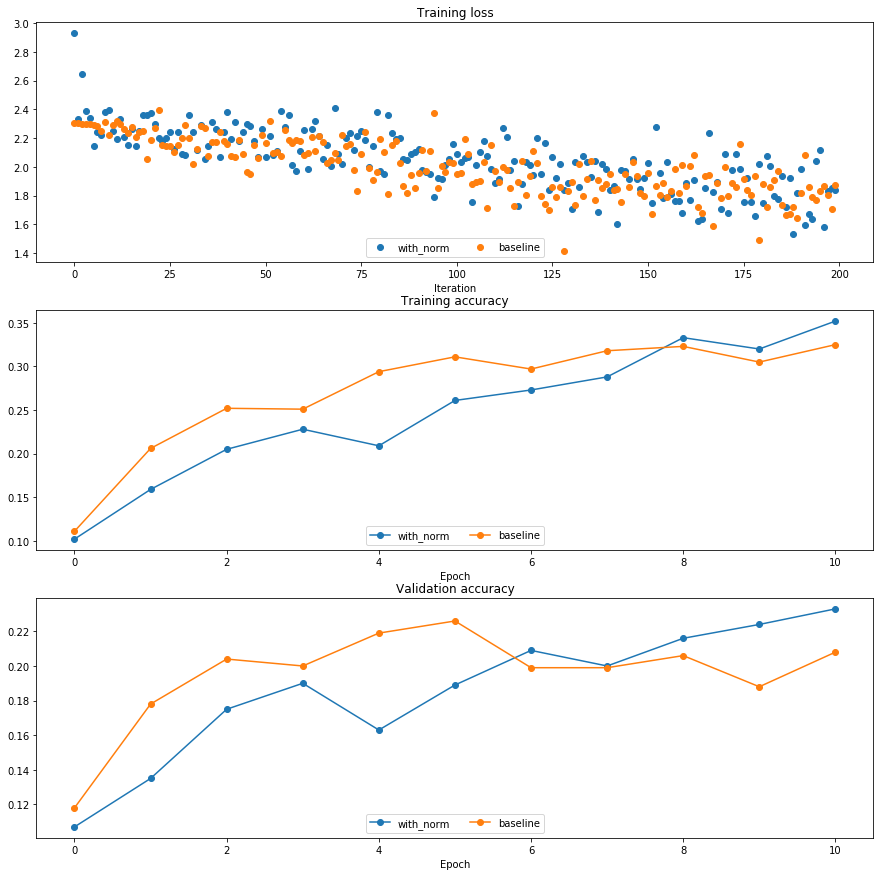

In [81]:
def plot_training_history(title, label, baseline, bn_solvers, plot_fn, bl_marker='.', bn_marker='.', labels=None):
    """utility function for plotting training history"""
    plt.title(title)
    plt.xlabel(label)
    bn_plots = [plot_fn(bn_solver) for bn_solver in bn_solvers]
    bl_plot = plot_fn(baseline)
    num_bn = len(bn_plots)
    for i in range(num_bn):
        label='with_norm'
        if labels is not None:
            label += str(labels[i])
        plt.plot(bn_plots[i], bn_marker, label=label)
    label='baseline'
    if labels is not None:
        label += str(labels[0])
    plt.plot(bl_plot, bl_marker, label=label)
    plt.legend(loc='lower center', ncol=num_bn+1) 

    
plt.subplot(3, 1, 1)
plot_training_history('Training loss','Iteration', solver, [bn_solver], \
                      lambda x: x.loss_history, bl_marker='o', bn_marker='o')
plt.subplot(3, 1, 2)
plot_training_history('Training accuracy','Epoch', solver, [bn_solver], \
                      lambda x: x.train_acc_history, bl_marker='-o', bn_marker='-o')
plt.subplot(3, 1, 3)
plot_training_history('Validation accuracy','Epoch', solver, [bn_solver], \
                      lambda x: x.val_acc_history, bl_marker='-o', bn_marker='-o')

plt.gcf().set_size_inches(15, 15)
plt.show()

# Batch normalization and initialization
We will now run a small experiment to study the interaction of batch normalization and weight initialization.

The first cell will train 8-layer networks both with and without batch normalization using different scales for weight initialization. The second layer will plot training accuracy, validation set accuracy, and training loss as a function of the weight initialization scale.

In [82]:
np.random.seed(231)
# Try training a very deep net with batchnorm
hidden_dims = [50, 50, 50, 50, 50, 50, 50]
num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

bn_solvers_ws = {}
solvers_ws = {}
weight_scales = np.logspace(-4, 0, num=20)
for i, weight_scale in enumerate(weight_scales):
  print('Running weight scale %d / %d' % (i + 1, len(weight_scales)))
  bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization='batchnorm')
  model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=None)

  bn_solver = Solver(bn_model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
  bn_solver.train()
  bn_solvers_ws[weight_scale] = bn_solver

  solver = Solver(model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
  solver.train()
  solvers_ws[weight_scale] = solver

Running weight scale 1 / 20
Running weight scale 2 / 20
Running weight scale 3 / 20
Running weight scale 4 / 20
Running weight scale 5 / 20
Running weight scale 6 / 20
Running weight scale 7 / 20
Running weight scale 8 / 20
Running weight scale 9 / 20
Running weight scale 10 / 20
Running weight scale 11 / 20
Running weight scale 12 / 20
Running weight scale 13 / 20
Running weight scale 14 / 20
Running weight scale 15 / 20
Running weight scale 16 / 20
Running weight scale 17 / 20
Running weight scale 18 / 20
Running weight scale 19 / 20
Running weight scale 20 / 20


Text(0.5,1,'Best val accuracy vs weight initialization scale')

Text(0.5,0,'Weight initialization scale')

Text(0,0.5,'Best val accuracy')

Text(0.5,1,'Best train accuracy vs weight initialization scale')

Text(0.5,0,'Weight initialization scale')

Text(0,0.5,'Best training accuracy')

Text(0.5,1,'Final training loss vs weight initialization scale')

Text(0.5,0,'Weight initialization scale')

Text(0,0.5,'Final training loss')

(1.0, 3.5)

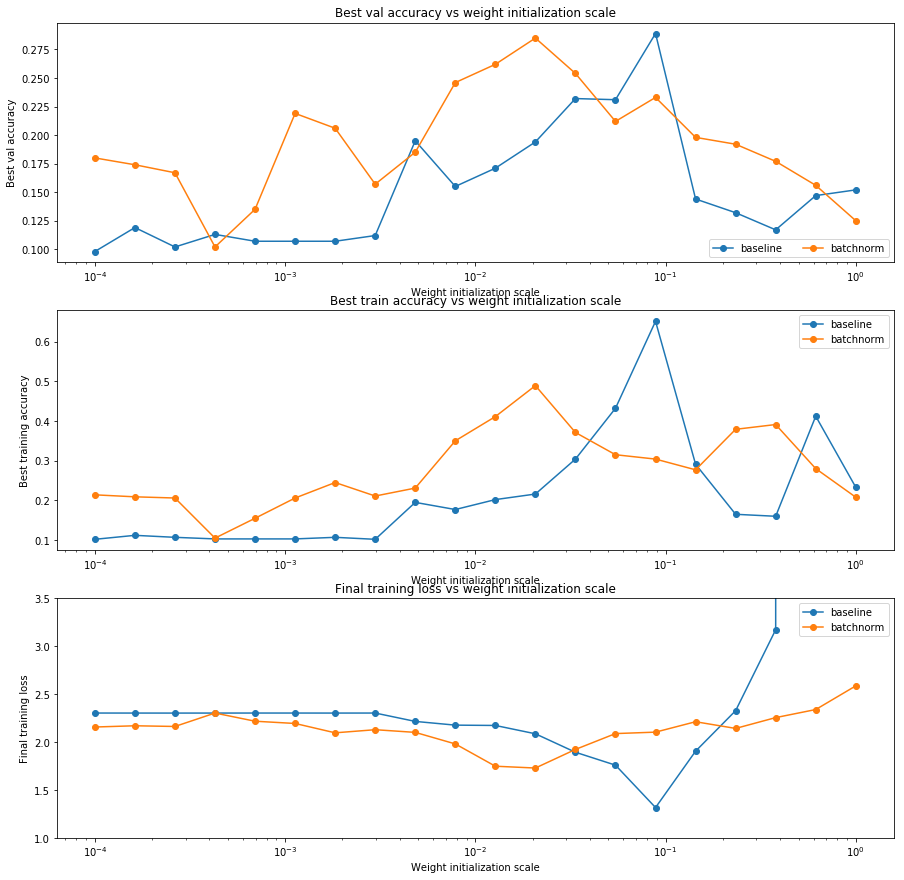

In [83]:
# Plot results of weight scale experiment
best_train_accs, bn_best_train_accs = [], []
best_val_accs, bn_best_val_accs = [], []
final_train_loss, bn_final_train_loss = [], []

for ws in weight_scales:
  best_train_accs.append(max(solvers_ws[ws].train_acc_history))
  bn_best_train_accs.append(max(bn_solvers_ws[ws].train_acc_history))
  
  best_val_accs.append(max(solvers_ws[ws].val_acc_history))
  bn_best_val_accs.append(max(bn_solvers_ws[ws].val_acc_history))
  
  final_train_loss.append(np.mean(solvers_ws[ws].loss_history[-100:]))
  bn_final_train_loss.append(np.mean(bn_solvers_ws[ws].loss_history[-100:]))
  
plt.subplot(3, 1, 1)
plt.title('Best val accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best val accuracy')
plt.semilogx(weight_scales, best_val_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_val_accs, '-o', label='batchnorm')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.title('Best train accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best training accuracy')
plt.semilogx(weight_scales, best_train_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_train_accs, '-o', label='batchnorm')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Final training loss vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Final training loss')
plt.semilogx(weight_scales, final_train_loss, '-o', label='baseline')
plt.semilogx(weight_scales, bn_final_train_loss, '-o', label='batchnorm')
plt.legend()
plt.gca().set_ylim(1.0, 3.5)

plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 1:
Describe the results of this experiment. How does the scale of weight initialization affect models with/without batch normalization differently, and why?

## Answer:


# Batch normalization and batch size
We will now run a small experiment to study the interaction of batch normalization and batch size.

The first cell will train 6-layer networks both with and without batch normalization using different batch sizes. The second layer will plot training accuracy and validation set accuracy over time.

In [84]:
def run_batchsize_experiments(normalization_mode):
    np.random.seed(231)
    # Try training a very deep net with batchnorm
    hidden_dims = [100, 100, 100, 100, 100]
    num_train = 1000
    small_data = {
      'X_train': data['X_train'][:num_train],
      'y_train': data['y_train'][:num_train],
      'X_val': data['X_val'],
      'y_val': data['y_val'],
    }
    n_epochs=10
    weight_scale = 2e-2
    batch_sizes = [5,10,50]
    lr = 10**(-3.5)
    solver_bsize = batch_sizes[0]

    print('No normalization: batch size = ',solver_bsize)
    model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=None)
    solver = Solver(model, small_data,
                    num_epochs=n_epochs, batch_size=solver_bsize,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': lr,
                    },
                    verbose=False)
    solver.train()
    
    bn_solvers = []
    for i in range(len(batch_sizes)):
        b_size=batch_sizes[i]
        print('Normalization: batch size = ',b_size)
        bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=normalization_mode)
        bn_solver = Solver(bn_model, small_data,
                        num_epochs=n_epochs, batch_size=b_size,
                        update_rule='adam',
                        optim_config={
                          'learning_rate': lr,
                        },
                        verbose=False)
        bn_solver.train()
        bn_solvers.append(bn_solver)
        
    return bn_solvers, solver, batch_sizes

batch_sizes = [5,10,50]
bn_solvers_bsize, solver_bsize, batch_sizes = run_batchsize_experiments('batchnorm')

No normalization: batch size =  5
Normalization: batch size =  5
Normalization: batch size =  10
Normalization: batch size =  50


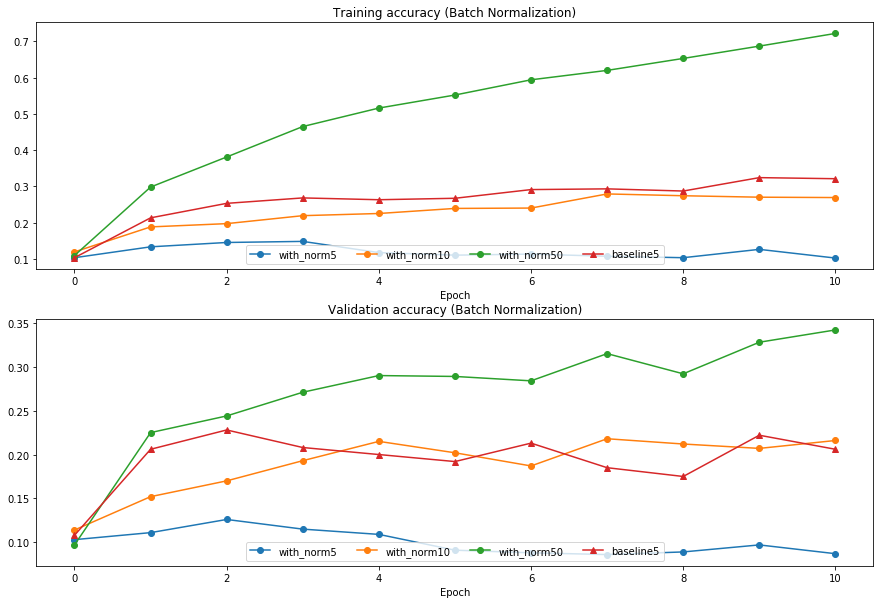

In [85]:
plt.subplot(2, 1, 1)
plot_training_history('Training accuracy (Batch Normalization)','Epoch', solver_bsize, bn_solvers_bsize, \
                      lambda x: x.train_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)
plt.subplot(2, 1, 2)
plot_training_history('Validation accuracy (Batch Normalization)','Epoch', solver_bsize, bn_solvers_bsize, \
                      lambda x: x.val_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)

plt.gcf().set_size_inches(15, 10)
plt.show()

## Inline Question 2:
Describe the results of this experiment. What does this imply about the relationship between batch normalization and batch size? Why is this relationship observed?

## Answer:


# Layer Normalization
Batch normalization has proved to be effective in making networks easier to train, but the dependency on batch size makes it less useful in complex networks which have a cap on the input batch size due to hardware limitations. 

Several alternatives to batch normalization have been proposed to mitigate this problem; one such technique is Layer Normalization [4]. Instead of normalizing over the batch, we normalize over the features. In other words, when using Layer Normalization, each feature vector corresponding to a single datapoint is normalized based on the sum of all terms within that feature vector.

[4] [Ba, Jimmy Lei, Jamie Ryan Kiros, and Geoffrey E. Hinton. "Layer Normalization." stat 1050 (2016): 21.](https://arxiv.org/pdf/1607.06450.pdf)

## Inline Question 3:
Which of these data preprocessing steps is analogous to batch normalization, and which is analogous to layer normalization?

1. Scaling each image in the dataset, so that the RGB channels for each row of pixels within an image sums up to 1.
2. Scaling each image in the dataset, so that the RGB channels for all pixels within an image sums up to 1.  
3. Subtracting the mean image of the dataset from each image in the dataset.
4. Setting all RGB values to either 0 or 1 depending on a given threshold.

## Answer:


# Layer Normalization: Implementation

Now you'll implement layer normalization. This step should be relatively straightforward, as conceptually the implementation is almost identical to that of batch normalization. One significant difference though is that for layer normalization, we do not keep track of the moving moments, and the testing phase is identical to the training phase, where the mean and variance are directly calculated per datapoint.

Here's what you need to do:

* In `cs231n/layers.py`, implement the forward pass for layer normalization in the function `layernorm_backward`. 

Run the cell below to check your results.
* In `cs231n/layers.py`, implement the backward pass for layer normalization in the function `layernorm_backward`. 

Run the second cell below to check your results.
* Modify `cs231n/classifiers/fc_net.py` to add layer normalization to the `FullyConnectedNet`. When the `normalization` flag is set to `"layernorm"` in the constructor, you should insert a layer normalization layer before each ReLU nonlinearity. 

Run the third cell below to run the batch size experiment on layer normalization.

In [156]:
# Check the training-time forward pass by checking means and variances
# of features both before and after layer normalization   

# Simulate the forward pass for a two-layer network
np.random.seed(231)
N, D1, D2, D3 =4, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before layer normalization:')
print_mean_std(a,axis=1)

gamma = np.ones(D3)
beta = np.zeros(D3)
# Means should be close to zero and stds close to one
print('After layer normalization (gamma=1, beta=0)')
a_norm, _ = layernorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=1)

gamma = np.asarray([3.0,3.0,3.0])
beta = np.asarray([5.0,5.0,5.0])
# Now means should be close to beta and stds close to gamma
print('After layer normalization (gamma=', gamma, ', beta=', beta, ')')
a_norm, _ = layernorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=1)

Before layer normalization:
  means:  [-59.06673243 -47.60782686 -43.31137368 -26.40991744]
  stds:   [10.07429373 28.39478981 35.28360729  4.01831507]

After layer normalization (gamma=1, beta=0)
  means:  [ 4.62592927e-17 -2.31296463e-18  4.62592927e-18 -1.48029737e-16]
  stds:   [0.09926254 0.03521773 0.02834177 0.24886052]

After layer normalization (gamma= [3. 3. 3.] , beta= [5. 5. 5.] )
  means:  [5. 5. 5. 5.]
  stds:   [0.29778762 0.10565319 0.08502532 0.74658156]



In [163]:
a = np.array([[1,2,3],[2,3,4]])
a
a.sum(axis =1)

array([[1, 2, 3],
       [2, 3, 4]])

array([6, 9])

In [184]:
# Gradient check batchnorm backward pass
np.random.seed(231)
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

ln_param = {}
fx = lambda x: layernorm_forward(x, gamma, beta, ln_param)[0]
fg = lambda a: layernorm_forward(x, a, beta, ln_param)[0]
fb = lambda b: layernorm_forward(x, gamma, b, ln_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma.copy(), dout)
db_num = eval_numerical_gradient_array(fb, beta.copy(), dout)

_, cache = layernorm_forward(x, gamma, beta, ln_param)
dx, dgamma, dbeta = layernorm_backward(dout, cache)

#You should expect to see relative errors between 1e-12 and 1e-8
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  1.0
dgamma error:  2.478519543348731e-12
dbeta error:  2.276445013433725e-12


# Layer Normalization and batch size

We will now run the previous batch size experiment with layer normalization instead of batch normalization. Compared to the previous experiment, you should see a markedly smaller influence of batch size on the training history!

No normalization: batch size =  5
Normalization: batch size =  5
Normalization: batch size =  10
Normalization: batch size =  50


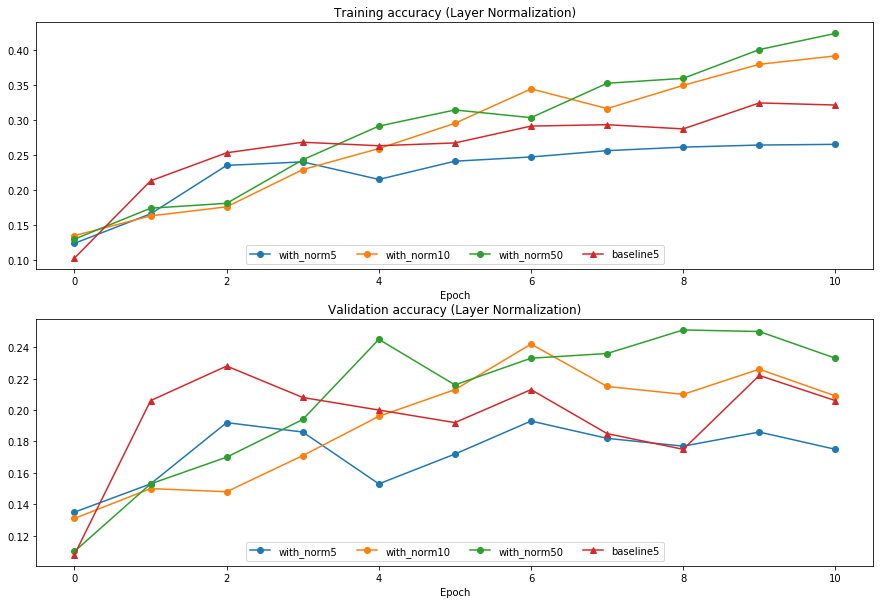

In [185]:
ln_solvers_bsize, solver_bsize, batch_sizes = run_batchsize_experiments('layernorm')

plt.subplot(2, 1, 1)
plot_training_history('Training accuracy (Layer Normalization)','Epoch', solver_bsize, ln_solvers_bsize, \
                      lambda x: x.train_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)
plt.subplot(2, 1, 2)
plot_training_history('Validation accuracy (Layer Normalization)','Epoch', solver_bsize, ln_solvers_bsize, \
                      lambda x: x.val_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)

plt.gcf().set_size_inches(15, 10)
plt.show()

## Inline Question 4:
When is layer normalization likely to not work well, and why?

1. Using it in a very deep network
2. Having a very small dimension of features
3. Having a high regularization term


## Answer:

with norm5
1